Import libraries:

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from hpsklearn import HyperoptEstimator, random_forest_classifier

from graphdatascience import GraphDataScience

## 1. Problem statement

Classify dataset of academic papers into categories using the [Cora dataset](https://paperswithcode.com/dataset/cora).

- A research paper citation network
- 2708 **Paper** nodes
- 5429 **CITES** relationships
- Each **Paper** node has a length 1433 binary _feature vector_
  - Each dimension represents a keyword
  - Value 1 if paper has keyword, 0 otherwise
- Each paper node belongs to a subject

<p align="center" width="100%">
    <img src="assets/cora_overview.png" width="70%"/>
</p>

In [68]:
nodes = pd.read_csv("data/nodes.csv", converters={"features": eval})
nodes.set_index("id")[["subject", "features"]]

,subject,features
id,,
31336,Neural_Networks,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1061127,Rule_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1106406,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13195,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
37879,Probabilistic_Methods,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
1128975,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1128977,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1128978,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Papers also have citations to other papers; citations connect `source` papers to `target` papers:

In [4]:
edges = pd.read_csv("data/edges.csv")
edges[["source", "target"]]

,source,target
0,1033,35
1,103482,35
2,103515,35
3,1050679,35
4,1103960,35
...,...,...
5424,19621,853116
5425,853155,853116
5426,1140289,853118
5427,853118,853155


Look at classes:

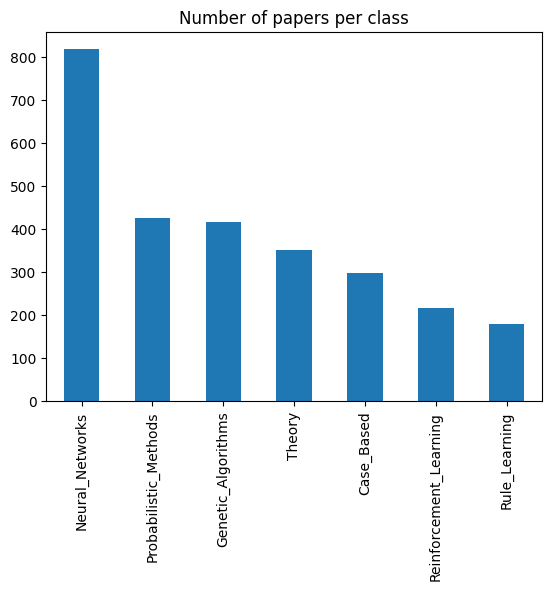

In [64]:
nodes["subject"].value_counts().plot.bar(title="Number of papers per class");

## 2. Tabular classification

In a traditional ML system, we use features of each sample independently of other nodes to classify. We cannot easily model each paper's citations in a tabular data format. 

**Therefore we will only use text features for classifying our papers dataset.**

> Note: We could construct aggregate numerical features such as how many times each paper cites another paper in a particular category. However this loses information about the spatial structure of the graph. It is hard to randomly split into train-test whilst preventing data leakage. 

![](assets/classifiers_tabular.png)

Get features and classes from dataset:

In [6]:
X = nodes["features"].apply(pd.Series).to_numpy()
y = nodes["subject"].astype("category").cat.codes.to_numpy()

Perform train-test split using `scikit-learn` and use `hyperopt-sklearn` to train a Random Forest Classifier and automatically train hyperparameters:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
classifier = HyperoptEstimator(classifier=random_forest_classifier("myclf"), trial_timeout=10, seed=1)

In [9]:
classifier.fit(X_train, y_train)

100%|██████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  6.67s/trial, best loss: 0.2702702702702703]


Calculate the classifier accuracy on the test set:

In [30]:
f"Accuracy: {format(classifier.score(X_test, y_test), '.0%')}"

'Accuracy: 74%'

## 3. Graph data classification

This problem is a classic graph data modelling problem. We now can use the citations data since they can be modelled by a graph data format. 

We can leverage this data model to visualise and extract useful information about the data:

<img src="https://dist.neo4j.com/wp-content/uploads/20220921212117/cora-dataset.png" width="80%"/>

How do we use the graph for classification? We create spatial features ("embeddings") for each data point based on their position in the graph. These features can be used for classification. 

<!---
![](https://dist.neo4j.com/wp-content/uploads/20220921212050/chaos-structure.png)
--> 
![](https://upload.wikimedia.org/wikipedia/commons/3/3f/KnowledgeGraphEmbedding.png)

#### What are embeddings?

> Node embedding algorithms compute low-dimensional vector representations of nodes in a graph. These vectors, also called embeddings, can be used for machine learning. 
>
> The FastRP algorithm operates on graphs, in which case we care about preserving similarity between nodes and their neighbors. This means that two nodes that have similar neighborhoods should be assigned similar embedding vectors. Conversely, two nodes that are not similar should be not be assigned similar embedding vectors.

![](https://gearons.org/assets/img/mage_example.png)

We create the embeddings using the [FastRP](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/) algorithm.

![](assets/classifiers_graph.png)

Note: Both FastRP and the downstream classification are statistical techniques and are analogous to simple NLP techniques. We don't touch on GNNs here (analogous to transformers for text, see [here](https://graphdeeplearning.github.io/post/transformers-are-gnns/) for interesting commentary).

### 3.1 Load dataset into Neo4j

1. In Neo4j Desktop, start a local DBMS and install the Graph Data Science Library and APOC plugins.
2. Move the data ([source](https://github.com/Kristof-Neys/Neo4j-Cora)) from this repo `cora/data/*.csv` to the database's `import` folder. You can find this under `Open/Open folder/Import` in Neo4j Desktop.
3. Load the `csv`s into Neo4j using the following Cypher commands:

In [31]:
#| code-fold: true
#| code-summary: "Connect to Neo4j instance"
from getpass import getpass
auth = ("neo4j", getpass("Password:"))
bolt = "bolt://localhost:7687/neo4j"
gds = GraphDataScience(bolt, auth=auth)

Password: ········


In [14]:
#| code-fold: true
#| code-summary: "Load data from CSV into Neo4j"

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM "file:///nodes.csv" AS row
WITH toInteger(row.id) AS paperId, row.subject AS subject, row.features AS features
MERGE (p:Paper {paper_Id: paperId})
SET p.subject = subject, p.features = apoc.convert.fromJsonList(features)
RETURN count(p)
""")

gds.run_cypher("""
LOAD CSV WITH HEADERS FROM "file:///edges.csv" AS row
MATCH(source: Paper {paper_Id: toInteger(row.source)})
MATCH(target: Paper {paper_Id: toInteger(row.target)})
MERGE (source)-[r:CITES]->(target)
""")

""


Visualise graph using cypher queries in Neo4j Browser, such as (after colouring nodes with Subject):

`MATCH (p:Paper) -[:CITES]-> (q:Paper) RETURN p,q LIMIT 200`

![](assets/graph.png)

### 3.2. Preprocess and project

Use the `gds` GraphDataScience client to connect to Neo4j and process the graph. Firstly run simple Cypher query to make categorical label from subject:

In [15]:
gds.run_cypher("""
MATCH (p:Paper)
SET p.subjectClass = {
    Neural_Networks: 0, Rule_Learning: 1, Reinforcement_Learning: 2, Probabilistic_Methods: 3, Theory: 4, Genetic_Algorithms: 5, Case_Based: 6
}[p.subject];
""")

""


Then project graph to in-memory and return Python object:

In [32]:
G, _ = gds.graph.project(
   "cora-graph",
   {"Paper": {"properties": ["subjectClass"]} },
   {"CITES": {"orientation": "UNDIRECTED", "aggregation": "SINGLE"}}
);

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

In [67]:
#| code-fold: true
#| code-summary: Check graph memory usage"
G.memory_usage()

'2318 KiB'

### 3.3. Create node embedding vectors
We use embedding vector dimension of 128. We can directly call Neo4j's fastRP algorithm from the Python client.

In [34]:
result = gds.fastRP.mutate(
   G,
   featureProperties=None,
   embeddingDimension=128,
   iterationWeights=[0, 0, 1.0, 1.0],
   normalizationStrength=0.05,
   mutateProperty="fastRP_Extended_Embedding"
)

After calling FastRP, stream the results back into Python. Each row of `X` is a 128-dimensional vector representing one paper.

In [35]:
X = gds.graph.streamNodeProperty(G, 'fastRP_Extended_Embedding')["propertyValue"].apply(pd.Series)

In [36]:
y = gds.graph.streamNodeProperty(G, 'subjectClass')["propertyValue"]

To visualise the embeddings, we use [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm to compress the 128-dimensional vectors into 2D.

In [37]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=0).fit_transform(X)

Plot the 2D embeddings of the papers, coloured by subject:

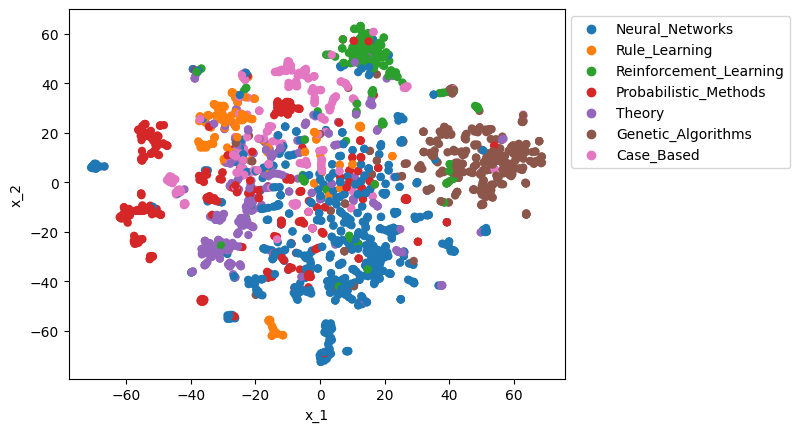

In [66]:
import seaborn as sns
df_tsne = pd.DataFrame({"x_1": X_tsne[:, 0], "x_2": X_tsne[:, 1], "y": nodes["subject"]})
sns.scatterplot(df_tsne, x="x_1", y="x_2", hue="y", edgecolor="none").legend(bbox_to_anchor=(1, 1));

We see that in a severely compressed 2D view, papers are clustered into their classes.

### 3.4 Perform classification with embedding vectors

**Note** GDS offers complete ML pipelines for data splitting, training classification models, hyperparameter tuning and inferencing. This is advantageous as it acts directly on embeddings which are stored in the in-memory graph, reducing need to move data. However here we export the embeddings and demonstrate using `scikit-learn` for familiarity.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
classifier = HyperoptEstimator(classifier=random_forest_classifier("myclf"), trial_timeout=10, seed=1)

In [23]:
classifier.fit(X_train, y_train)

100%|█████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  4.06s/trial, best loss: 0.16953316953316955]


Calculate classifier accuracy on test set:

In [24]:
f"Accuracy: {format(classifier.score(X_test, y_test), '.0%')}"

0.8478581979320532

## References

Following [tutorial](https://neo4j.com/blog/machine-learning-innovation-predictive-analysis/). Some images sourced from [here](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/). Embedding images [source](https://commons.wikimedia.org/wiki/File:KnowledgeGraphEmbedding.png) and [source](https://gearons.org/blog/2016/MAGE/).